# 1. Multi-class Weather Dataset
[Multi-class Weather Dataset]('https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset')은 다양한 기상 조건을 포함하는 이미지 데이터셋으로, 주로 기계 학습 및 딥러닝 모델을 학습하거나 평가하는 데 사용됩니다. 이 데이터셋은 맑음, 비, 눈, 흐림과 같은 여러 날씨 유형으로 라벨이 지정된 다중 클래스 분류 문제를 다룹니다. 각 클래스는 다양한 시간대, 계절, 지역에서 촬영된 이미지를 포함하여 현실 세계의 다양성을 반영하도록 설계되었습니다. 이를 통해 모델은 날씨 조건을 정확히 분류하고, 기상 관측, 자동화된 날씨 보고, 혹은 자율주행 차량의 환경 인식 시스템과 같은 다양한 응용 분야에서 활용될 수 있습니다.

### Kaggle CLI (원격으로 끌어오는 방법)
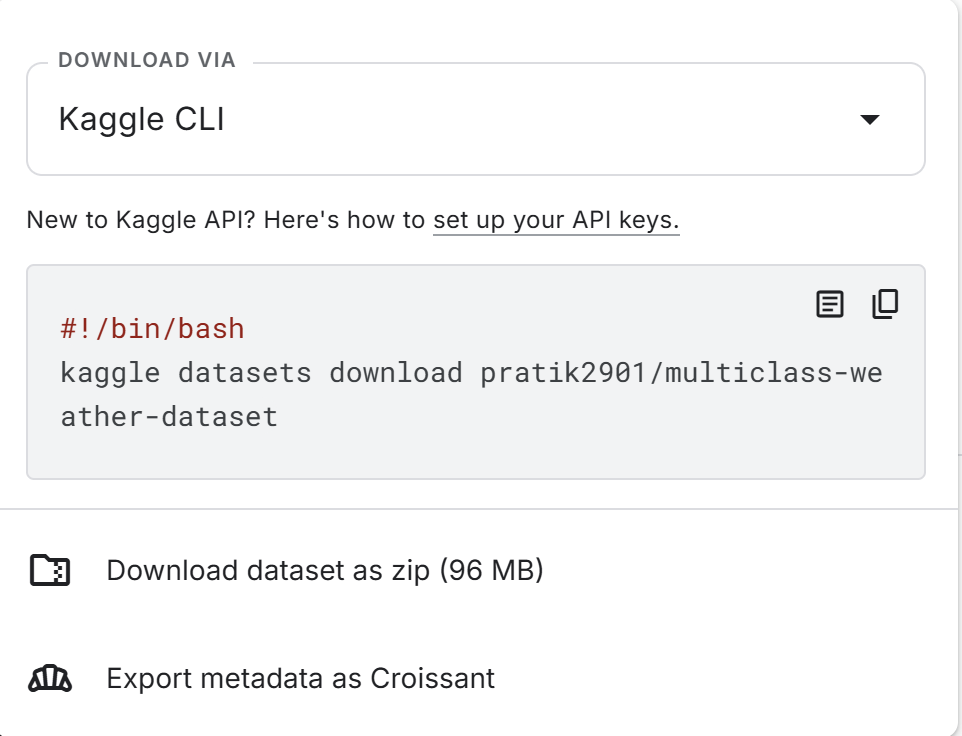

In [1]:
from google.colab import files
files.upload()  # kaggle.json 업로드 창 표시
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
#!/bin/bash
!kaggle datasets download pratik2901/multiclass-weather-dataset

Dataset URL: https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/91.4M [00:00<?, ?B/s]
100% 91.4M/91.4M [00:00<00:00, 978MB/s]


In [3]:
import os
import zipfile
import random
from shutil import copyfile, rmtree

zip_file = 'multiclass-weather-dataset.zip'
base_dir = './Multi-class Weather Dataset'
train_dir = './train'
test_dir = './test'
extract_path = '.'  # 폴더 생성 없이 현재 디렉터리에 압축 해제

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_path) # 전체 ref를 다 풀겠다.

# 분류 디렉터리 목록
categories = ['Cloudy', 'Rain', 'Shine', 'Sunrise']

# 1) train_dir 폴더가 실제로 존재하는지 확인
if os.path.exists(train_dir):
    # 2) 존재한다면 해당 폴더와 내부의 모든 내용을 삭제
    rmtree(train_dir)

# 3) test_dir 폴더가 실제로 존재하는지 확인
if os.path.exists(test_dir):
    # 4) 존재한다면 해당 폴더와 내부의 모든 내용을 삭제
    rmtree(test_dir)

# train, test 폴더 및 하위 카테고리 폴더 생성
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

# 각 카테고리별 데이터 파일 나누기
for category in categories:
    category_path = os.path.join(base_dir, category)
    files = os.listdir(category_path) # 파일들을 리스트로 가져오세요

    # 데이터 섞기
    random.shuffle(files)

    # 데이터 나누기 (8:2 비율)
    split_idx = int(len(files) * 0.8)
    train_files = files[:split_idx]
    test_files = files[split_idx:]

    # 파일 복사
    for file in train_files:
        src = os.path.join(category_path, file)
        dst = os.path.join(train_dir, category, file)
        copyfile(src, dst)

    for file in test_files:
        src = os.path.join(category_path, file)
        dst = os.path.join(test_dir, category, file)
        copyfile(src, dst)

print("데이터 분리가 완료되었습니다.")

데이터 분리가 완료되었습니다.


In [4]:
import torch
import time
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torchvision.utils import make_grid
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np

In [5]:
# 데이터 증강
transform_train = transforms.Compose([
    transforms.Resize((256, 256)), #크기 맞추기
    transforms.RandomHorizontalFlip(), # 랜덤으로 좌우반전. 확률 50%
    transforms.ToTensor(), # 텐서로 바꿔주기 + 그 안 데이터 숫자를 정규화 (0~1사이로) -> 계산량을 줄여줄 수 있음, RGB 이미지 : (H, W, C) -> Tensor (C, H, W) (채널, 높이, 너비)로 바꿔줌
    transforms.Normalize( # 평균과 표준편차를 맞춰줌. [0.0 ~ 1.0] -> [-1.0 ~ 1.0] 범위가 바뀜
                         # 하는 이유? : 속도 유리, 계산량 감소, 텐서를 쓰면 0~1로 바뀌게 되는데, 보통 ReLU를 쓰면 0은 skip해버림.(죽은 기울기), 폭이 넓어지면 다른 값들이 들어감.
                          # 만약 x = [0.2, 0.4, 0.7, 0.9] 이렇게 들어가 있을 때? 모두 양수이기 때문에 그대로 통과, [0.2, 0.4, 0.7, 0.9]
                          # 만약 x = [-0.8, -0.2, 0.3, 0.9] 라면 ReLU를 통과하게 되면 -> [0,0,0.3,0.9]가 됨. ReLU가 일을 함. (가중치가 더 살 수 있는 역할)
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

# 테스트데이터는 증강을 시킬 필요가 없다. 오히려 정답이랑 비교해봐야하기 때문. (사이즈비교, 정규화,노멀라이즈는 하되, 증강은 시키지 않겠음!)
transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

train_dataset = datasets.ImageFolder(
    root='train/',
    transform=transform_train #train 폴더에서 가져오면서 transform_train을 통과시키면서 데이터 증강시킬 것
)

dataset_size = len(train_dataset) # 899개

# 검증도 해보기 (훈련/검증 -> 8: 2)
# 사이즈만 먼저 정해주기
train_size = int(dataset_size * 0.8)
val_size = dataset_size - train_size

# 사이킷런이 아닌, 다른 방법으로 데이터 나눠보기
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# 테스트 데이터 (이미 나눠놨던) 가져오기 (평가로만 쓸 거라서 나눌 필요 없음)
test_dataset = datasets.ImageFolder(
    root='test/',
    transform=transform_test
)

# 미니배치로 학습시킬 수 있도록 데이터로더 만들기
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

###※ transforms.ToTensor()

- 이미지를 PyTorch 텐서(tensor)로 변환합니다.
- 이미지의 픽셀 값을 [0, 255] 범위에서 [0.0, 1.0] 범위로 정규화합니다.
- 이미지의 차원을 (H, W, C) 형식에서 PyTorch에서 사용하는 (C, H, W) 형식으로 바꿉니다.
    - H: 이미지의 높이 (Height)
    - W: 이미지의 너비 (Width)
    - C: 채널(Channel; 예: RGB 이미지의 경우 3)

###※ transforms.Normalize(mean, std)

- 텐서로 변환된 이미지의 픽셀 값을 정규화(normalization)합니다.
- mean: 각 채널(R, G, B)의 평균값.
- std: 각 채널의 표준편차.
- mean=[0.5, 0.5, 0.5]: R, G, B 채널 각각의 평균을 0.5로 설정.
- std=[0.5, 0.5, 0.5]: R, G, B 채널 각각의 표준편차를 0.5로 설정.
- 이 정규화는 일반적으로 픽셀 값의 범위를 [−1,1][-1, 1][−1,1]로 조정하기 위해 사용됩니다. (픽셀 값이 [0,1][0, 1][0,1]로 변환된 상태에서)  
     - ReLU에서 좀 더 좋은 성과를 볼 수 있다!

###※ ImageFolder

- datasets.ImageFolder는 이미지 데이터를 특정 디렉터리 구조에서 로드하는 클래스입니다.
- 디렉터리 이름을 레이블(class label)로 간주하며, 각 디렉터리 내의 이미지 파일들을 해당 레이블에 할당합니다.
- 이 클래스는 이미지 데이터를 PyTorch 데이터셋(Dataset) 형식으로 변환하므로, DataLoader와 함께 사용하여 배치 처리 및 데이터 증강(data augmentation)을 쉽게 적용할 수 있습니다.

In [6]:
# 전체적인 환경 구성
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

In [7]:
# 여기에 이미지를 넣어주게 되면, 텐서로 집어넣으면 넘파이로 변환

def imshow(input):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0)) # 원래 있던 차원을 맨 뒤로 보내고 나머지 땡겨옴
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean # 정규화 해제 (역정규화)
    input = np.clip(input, 0, 1) # 값이 0보다 작은 경우 0, 1보다 큰 경우 1로 변환합니다.
    plt.imshow(input)
    plt.show()

In [8]:
class_names = {
    0:"Cloudy", 1:"Rain", 2:"Shine", 3:"Sunrise"
}

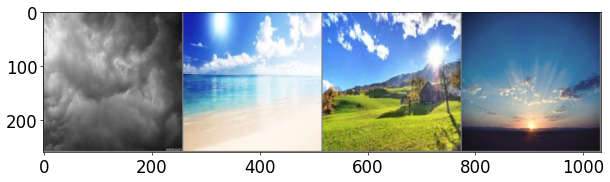

['Cloudy', 'Shine', 'Shine', 'Sunrise']


In [9]:
iterator = iter(train_dataloader)
imgs, labels = next(iterator) # 하나만 뽑아주기 (64쌍을 뽑을 것)
out = make_grid(imgs[:4]) # 여러 이미지를 하나의 격자 형태로 합침
imshow(out)

print([class_names[labels[i].item()] for i in range(4)])
# 예측한 거 아니고 순서대로 들어있는 거 뽑은 것.
# 여기까지 전처리 작업 해봄!

# 2. 다양한 모델 만들기


In [10]:
# 단일 선형 계층
# 활성화 함수나 추가 계층이 없으므로 모델이 표현할 수 있는 함수는 단순 선형 변환에 제한
# (256*256*3+1)*4 = 786,436

class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.linear1 = nn.Linear(256 * 256 * 3, 4) # 클래스가 4개
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x) # 이미지를 넣으면 1열로 만들어주겠다.
        x = self.linear1(x)
        return x

# 두 개의 선형 계층을 사용하여 입력 데이터를 단계적으로 압축
# (256*256*3+1)*64 + (64+1)*4 = 12,583,236

class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__() #부모 생성자 호출해주고
        self.linear1 = nn.Linear(256 * 256 * 3, 64) # 256 * 256 * 3을 받아서 64개짜리로 내보내겠다.
        self.linear2 = nn.Linear(64, 4) # 64개를 받아서 4개로 내보내겠다.
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x) # 이미지를 받아서 평평하게 1열로 만든다.
        x = self.linear1(x) # 선형 모델에 집어넣기 1
        x = self.linear2(x) # 선형 모델에 집어 넣기 2
        return x

# 이 모델 구조에서 이상한 점?
# 선형 2개 합쳐봐야 똑같은 녀석인데 왜 저걸 굳이 2개 만들어놨나?
# 2개 쓰면 파라미터만 늘어남. 사실은 히든레이어만 늘어난 것


In [11]:
# 다중 구조와 ReLU 활성화 함수를 사용하여 비선형적 특징을 학습할 수 있음
# Dropout을 통해 과적합을 방지
# (256*256*3+1)*128 + (128+1)*64 + (64+1)*32 + (32+1)*4 = 25176420

# 활성화 함수는 없음. 선형임

class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__() # 부모 생성자 호출
        self.linear1 = nn.Linear(256 * 256 * 3, 128)
        self.dropout1 = nn.Dropout(0.5) # 학습할 때, 노드 중에 50% 확률로 랜덤하게 얘를 꺼줌. (나머지 64개만 학습이 될 것)
        self.linear2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(64, 32)
        self.dropout3 = nn.Dropout(0.5)
        self.linear4 = nn.Linear(32, 4)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)  # 이미지를 넣어주면 일단 다 펼침
        x = F.relu(self.linear1(x)) # 1번 선형에 넣어서 곡선화 시킴 (활성화 함수) -> 하나의 모든 수식으로 합칠 수 없음
        x = self.dropout1(x)
        x = F.relu(self.linear2(x))
        x = self.dropout2(x)
        x = F.relu(self.linear3(x))
        x = self.dropout3(x)
        x = self.linear4(x)
        return x

### ※ nn.Module 상속

1. 모델 구성 요소 관리: 레이어와 파라미터를 자동으로 관리.
2. 순전파(Forward) 정의: forward() 메서드를 통해 간단하고 일관된 순전파 과정 정의.
3. 계층적 설계: 서브모듈을 활용해 복잡한 모델을 쉽게 설계.
4. 유틸리티 제공: 파라미터 저장/로드, 학습/추론 모드 전환 등 다양한 기능 제공.
5. PyTorch 호환성: 최적화, 데이터 로더 등 PyTorch의 다른 기능과 손쉽게 통합.
6. 추상화: 저수준 작업을 추상화하여 개발자의 생산성을 향상.

### ※ Dropout

nn.Dropout()은 PyTorch에서 제공하는 과적합(overfitting)을 방지하기 위한 레이어입니다. 드롭아웃은 학습 과정 중 일부 뉴런을 무작위로 "비활성화(drop)"함으로써, 모델이 특정 뉴런에 지나치게 의존하지 않도록 도와줍니다. 이를 통해 모델의 일반화 성능이 향상됩니다.

In [12]:
# 학습시킬 때 여러 기능들을 함수로 묶어두기

def train():
    start_time = time.time() # 학습이 시작될 때 시간 저장
    print(f'[Epoch: {epoch + 1} - Training]') # 학습이 시작되는 모드라는 것을 print로 출력해주기
    model.train() # 모델이 그래디언트를 메모리에 올리게되고, train 모드로 동작하게 된다.
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(train_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda() # GPU로 보낸 값들을 변수에 저장 (돌리기 전에 GPU를 무조건 쓰게 만들어야 함)

        outputs = model(imgs) #모델에 imgs를 넣어서 예측을 할 것
        optimizer.zero_grad() # 초기화
        _, preds = torch.max(outputs, 1) # 실제 초기화시켜준 후에 예측값 중 최댓값을 뽑고, 그걸 preds에 출력한다. outputs 값에 해당하는 애는 필요 없어서 _ 처리함
        loss = criterion(outputs, labels) # 이건 나중에 만들어줄 것. (오차를 구해주는 역할)

        loss.backward() # 역전파
        optimizer.step() # 가중치 적용

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data) # 예측값과 라벨의 정답값을 꺼내서 맞으면 1씩 계속 더해줌

        if i % log_step == 0: # 100번마다라던지.. 1000번마다 라던지.. print를 찍기 위해서
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}') # 학습 loss, acc 출력 (배치마다 계산)

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time) # 에폭 수행에 걸린 시간(초) 계산
    return running_loss / total, (running_corrects / total).item()

# 검증할 때 함수
def validate():
    start_time = time.time() # 현재 시간을 저장하게 하고,
    print(f'[Epoch: {epoch + 1} - Validation]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(val_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad(): # with 범위 권 안에서는 그라디언트를 꺼주는 역할을 하고, (학습이 꺼지게 되고)
            outputs = model(imgs) # 학습을 위한 예측이 아니라 검증을 위한 예측을 하게 됨
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data) # 검증을 위한 용도

        if i % log_step == 0:
            print(f'[Batch: {i + 1}] running val loss: {running_loss / total}, running val accuracy: {running_corrects / total}')

    print(f'val loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

# 테스트할 때 돌릴 함수
def test():
    start_time = time.time()
    print(f'[Test]')
    model.eval() # 테스트 모드로 돌리겠다 라는 뜻 (학습도 아니고, 학습에 필요한 모든 메모리가 사라지게 됨. 평가만 할 수 있게 됨)
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i % log_step == 0:
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

In [13]:
# 학습률도 조금씩 조정할 수 있는 함수

def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 3:
        lr /= 10
    if epoch >= 7:
        lr /= 10 # 점점 보폭이 줄어들 것
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

[Epoch: 1 - Training]
[Batch: 1] running train loss: 0.024974847212433815, running train accuracy: 0.171875
[Batch: 9] running train loss: 0.3410264677885506, running train accuracy: 0.5503472089767456
train loss: 0.3370608893820241, accuracy: 0.5910987854003906
elapsed time: 5.9672369956970215
[Epoch: 1 - Validation]
[Batch: 1] running val loss: 0.5974608659744263, running val accuracy: 0.625
val loss: 0.464016670650906, accuracy: 0.6833333373069763
elapsed time: 1.4168245792388916
[Info] best validation accuracy!
[Epoch: 2 - Training]
[Batch: 1] running train loss: 0.3428248465061188, running train accuracy: 0.75
[Batch: 9] running train loss: 0.3575296501318614, running train accuracy: 0.7065972089767456
train loss: 0.35852264197380057, accuracy: 0.6995827555656433
elapsed time: 4.878719091415405
[Epoch: 2 - Validation]
[Batch: 1] running val loss: 0.6222159266471863, running val accuracy: 0.5625
val loss: 0.5584603945414225, accuracy: 0.5833333730697632
elapsed time: 2.120216846466

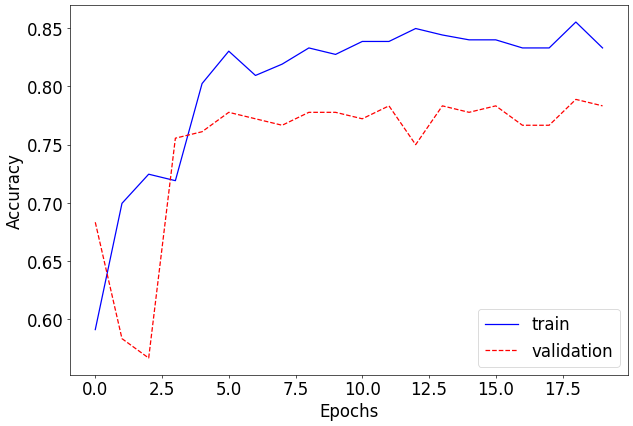

In [14]:
learning_rate = 0.01
log_step = 8

model = Model1()
model = model.cuda() # 모델 자체도 GPU로 보내기

criterion = nn.CrossEntropyLoss() # 나중에 실험할 때 모델 바꿔서 해볼 수 있음
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

num_epochs = 20
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []

os.makedirs("weights/Model1", exist_ok=True)

for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))

    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f"weights/Model1/best_checkpoint_epoch_{epoch + 1}.pth")
        # 가장 좋은 acc를 출력한 모델의 가중치를 저장하기
torch.save(model.state_dict(), f"weights/Model1/last_checkpoint_epoch_{num_epochs}.pth")
# 다 학습이 끝나면 마지막것도 저장을 할 겨

plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")

[Epoch: 1 - Training]
[Batch: 1] running train loss: 0.021245749667286873, running train accuracy: 0.265625
[Batch: 9] running train loss: 0.06743717172907458, running train accuracy: 0.522569477558136
train loss: 0.10654199687098263, accuracy: 0.5201669335365295
elapsed time: 5.693936109542847
[Epoch: 1 - Validation]
[Batch: 1] running val loss: 0.6439496874809265, running val accuracy: 0.265625
val loss: 0.5851608064439562, accuracy: 0.3166666626930237
elapsed time: 1.4040470123291016
[Info] best validation accuracy!
[Epoch: 2 - Training]
[Batch: 1] running train loss: 0.6181433200836182, running train accuracy: 0.234375
[Batch: 9] running train loss: 0.5849037335978614, running train accuracy: 0.5104166865348816
train loss: 0.6497630171052935, accuracy: 0.509040355682373
elapsed time: 7.119696855545044
[Epoch: 2 - Validation]
[Batch: 1] running val loss: 1.069462776184082, running val accuracy: 0.5625
val loss: 1.0389624065823024, accuracy: 0.5444444417953491
elapsed time: 1.4474430

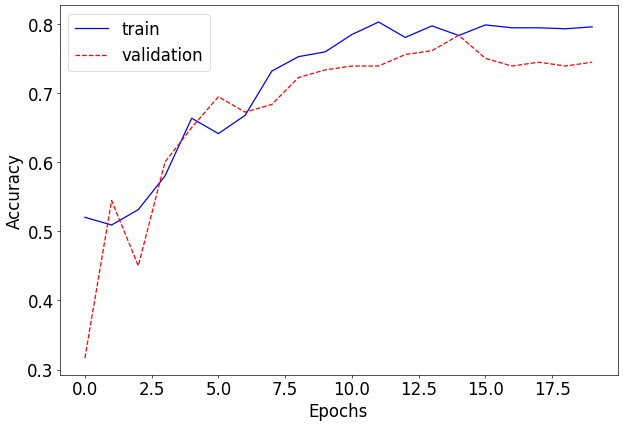

In [15]:
os.makedirs("weights/Model2", exist_ok=True)

learning_rate = 0.01
log_step = 8

model = Model2()
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

num_epochs = 20
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []
for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))

    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f"weights/Model2/best_checkpoint_epoch_{epoch + 1}.pth")

torch.save(model.state_dict(), f"weights/Model2/last_checkpoint_epoch_{num_epochs}.pth")

plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")

[Epoch: 1 - Training]
[Batch: 1] running train loss: 0.021784324198961258, running train accuracy: 0.203125
train loss: 0.021210638306237064, accuracy: 0.3518775999546051
elapsed time: 5.522167682647705
[Epoch: 1 - Validation]
[Batch: 1] running val loss: 0.0153622105717659, running val accuracy: 0.46875
val loss: 0.014796011646588643, accuracy: 0.550000011920929
elapsed time: 1.429244041442871
[Info] best validation accuracy!
[Epoch: 2 - Training]
[Batch: 1] running train loss: 0.01505736168473959, running train accuracy: 0.5625
train loss: 0.017876062257233514, accuracy: 0.5493741631507874
elapsed time: 5.777298927307129
[Epoch: 2 - Validation]
[Batch: 1] running val loss: 0.010591089725494385, running val accuracy: 0.71875
val loss: 0.012542008029090033, accuracy: 0.7111111283302307
elapsed time: 1.4268815517425537
[Info] best validation accuracy!
[Epoch: 3 - Training]
[Batch: 1] running train loss: 0.01861884444952011, running train accuracy: 0.46875
train loss: 0.01685853918006589

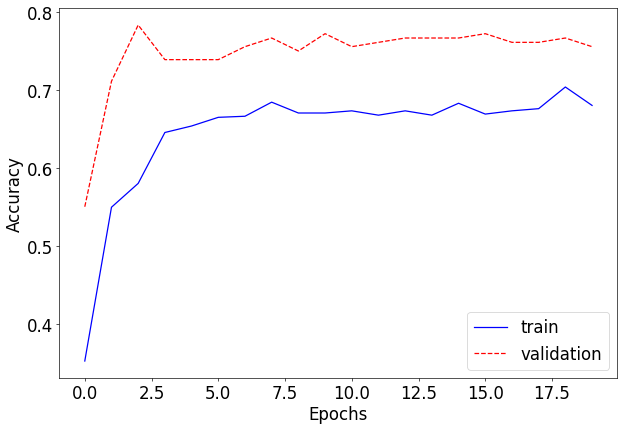

In [16]:
os.makedirs("weights/Model3", exist_ok=True)

learning_rate = 0.01
log_step = 20

model = Model3()
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

num_epochs = 20
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []

for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))

    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f"weights/Model3/best_checkpoint_epoch_{epoch + 1}.pth")

torch.save(model.state_dict(), f"weights/Model3/last_checkpoint_epoch_{num_epochs}.pth")

plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")

왜 모델 성능이 이렇게 좋지 못한가?  
- 일반적인 딥러닝은 데이터를 넣을 때 한 줄로넣기 때문.
    - 사진을 쪼개서 1줄로 들어가기 때문에 공간적인 값을 잃어버리게 됨.
    - 실질적인 x, y 좌표로 이해하지 못하기 때문에 실질적으로 학습이 잘 되지 않음
    - 딥러닝은 이미지 학습 잘 되지 않아요.
    - 공간 좌표 그대로 집어 넣는 게 CNN
    